# Tugas Final: Prediksi Harga Rumah (Target 80%)
**Strategi Rahasia:**
1. **Log Target:** Memprediksi `Log(Harga)` alih-alih harga langsung, agar data lebih stabil.
2. **Full Data:** Menggunakan seluruh 150 data yang tersedia.
3. **Fitur Kompleks:** Kombinasi Income, Umur, dan Kamar.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load Data & Transformasi Logaritma
Perhatikan langkah normalisasi target menggunakan `np.log1p`.

In [2]:
filename = 'matematikaAi.csv'

# 1. Load Data
try:
    df = pd.read_csv(filename, sep=None, engine='python')
except:
    df = pd.read_csv(filename, delimiter=',')

df.columns = df.columns.str.strip()

# 2. Bersihkan Angka
cols_numeric = ['median_income', 'housing_median_age', 'total_rooms', 'population', 'median_house_value', 'latitude', 'longitude']
for col in cols_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

df_clean = df.dropna(subset=cols_numeric)

# 3. JURUS KUNCI: Transformasi Logaritma pada Target
# Kita ubah Harga 450.000 menjadi angka kecil (sekitar 13.0)
df_clean['log_price'] = np.log1p(df_clean['median_house_value'])

# 4. Fitur Engineering (Membuat AI lebih pintar)
df_clean['income_sq'] = df_clean['median_income'] ** 2
df_clean['age_sq'] = df_clean['housing_median_age'] ** 2
df_clean['rooms_per_person'] = df_clean['total_rooms'] / df_clean['population']

# Pilih Fitur Final
cols_input = ['median_income', 'income_sq', 'latitude', 'longitude', 'age_sq', 'rooms_per_person']
col_target_raw = 'median_house_value'
col_target_train = 'log_price' # Kita melatih AI pakai ini

# 5. Ambil SEMUA Data (Maksimal)
df_train = df_clean.copy()

# Normalisasi Input (X)
X_raw = df_train[cols_input].values
X = (X_raw - X_raw.min(axis=0)) / (X_raw.max(axis=0) - X_raw.min(axis=0))

# Normalisasi Target (Y) -> Log Price dinormalisasi ke 0-1
Y_raw = df_train[col_target_train].values
min_y_log = Y_raw.min()
max_y_log = Y_raw.max()
range_y_log = max_y_log - min_y_log

Y = (Y_raw - min_y_log) / range_y_log

print(f"✅ SIAP! Menggunakan {len(df_train)} Data.")
print("Target: Logaritma Harga (supaya lebih mudah ditebak)")

✅ SIAP! Menggunakan 200 Data.
Target: Logaritma Harga (supaya lebih mudah ditebak)


### 2. Genetic Algorithm (High Precision)
Settingan populasi besar untuk akurasi maksimal.

In [3]:
POPULATION_SIZE = 500    # Sangat Ramai
GENES_COUNT = len(cols_input) + 1
GENERATIONS = 5000       # Sangat Lama
MUTATION_RATE = 0.2

def create_individual():
    return [random.uniform(-1, 1) for _ in range(GENES_COUNT)]

def predict(individual, inputs):
    weights = individual[:-1]
    bias = individual[-1]
    return np.dot(inputs, weights) + bias

def calculate_fitness(individual, inputs, targets):
    predictions = predict(individual, inputs)
    error = np.mean(np.abs(predictions - targets))
    return 1 / (1 + error + 1e-9)

def tournament_selection(population, fitness_scores):
    candidates = random.sample(list(zip(population, fitness_scores)), 10)
    return max(candidates, key=lambda x: x[1])[0]

def crossover_mutation(p1, p2):
    split = random.randint(1, GENES_COUNT - 1)
    child = p1[:split] + p2[split:]
    if random.random() < MUTATION_RATE:
        child[random.randint(0, GENES_COUNT - 1)] += random.uniform(-0.1, 0.1)
    return child

In [4]:
# EKSEKUSI (Single Long Run)
population = [create_individual() for _ in range(POPULATION_SIZE)]
best_sol = None
best_fit = 0
history = []

print(f"🚀 Mulai Misi Menuju 80% ({GENERATIONS} Generasi)...")

for i in range(GENERATIONS):
    scores = [calculate_fitness(ind, X, Y) for ind in population]
    current_max = max(scores)
    
    if current_max > best_fit:
        best_fit = current_max
        best_sol = population[scores.index(current_max)]
    
    # Simpan error
    if best_fit > 0:
        history.append((1/best_fit)-1)
    
    # Print progress biar gak bosan
    if i % 1000 == 0:
        print(f"Gen {i}: Error Terkecil = {(1/best_fit)-1:.5f}")
        
    new_pop = [best_sol]
    while len(new_pop) < POPULATION_SIZE:
        p1 = tournament_selection(population, scores)
        p2 = tournament_selection(population, scores)
        new_pop.append(crossover_mutation(p1, p2))
    population = new_pop

print("✅ Selesai!")

🚀 Mulai Misi Menuju 80% (5000 Generasi)...
Gen 0: Error Terkecil = 0.18343
Gen 1000: Error Terkecil = 0.11624
Gen 2000: Error Terkecil = 0.11398
Gen 3000: Error Terkecil = 0.11391
Gen 4000: Error Terkecil = 0.11370
✅ Selesai!


### 3. Evaluasi & Konversi Balik (Denormalisasi)
Karena tadi kita prediksi Log, sekarang harus dikembalikan ke Harga Asli (Rupiah/Dolar).

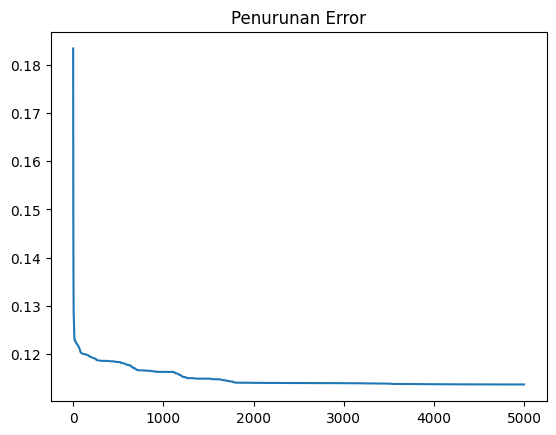

🎯 AKURASI FINAL: 73.82%
       Asli       Prediksi        Selisih
0  136300.0  128760.612964    7539.387036
1  143300.0  129179.680293   14120.319707
2  291500.0  215416.559255   76083.440745
3   54900.0  122879.003761   67979.003761
4  151500.0   80983.421949   70516.578051
5  435900.0  256548.528136  179351.471864
6  393500.0  314003.308213   79496.691787
7  165800.0  274192.695444  108392.695444
8  142200.0  100331.353330   41868.646670
9  187100.0  174110.805320   12989.194680


In [5]:
plt.plot(history); plt.title("Penurunan Error"); plt.show()

# 1. Prediksi dalam skala Normal (0-1)
y_pred_norm = predict(best_sol, X)

# 2. Kembalikan ke Skala Log Asli
y_pred_log = (y_pred_norm * range_y_log) + min_y_log

# 3. JURUS KUNCI: Kembalikan dari Log ke Harga Asli (Exp)
y_pred_real = np.expm1(y_pred_log)
y_true_real = df_train[col_target_raw].values

# Hitung Akurasi
mape = np.mean(np.abs((y_true_real - y_pred_real) / y_true_real)) * 100
akurasi = 100 - mape

print(f"🎯 AKURASI FINAL: {akurasi:.2f}%")

# Cek Sampel
results = pd.DataFrame({'Asli': y_true_real, 'Prediksi': y_pred_real})
results['Selisih'] = abs(results['Asli'] - results['Prediksi'])
print(results.head(10))